# Принятие решений в бизнесе, при помощи А/В-теста

Выступая в роли аналитика крупного интернет-магазина, вместе с отделом маркетинга подготовили список гипотез для увеличения выручки, запустим А/В-тест и проведем исследование.

**Цель проекта:**
- приоритизировать гипотезы;
- запустить A/B-тест и проанализировать результаты.

**Описание данных**: 

В нашем распоряжении три датасета: `hypothesis.csv` хранит 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort; `orders.csv` и `visitors.csv` — содержат результаты А/В-тестов.

Структура `hypothesis.csv`:
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Структура `orders.csv`:
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Структура `visitors.csv`:
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

## Откроем файлы с данными и изучим общую информацию

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')
except:
    hypothesis = pd.read_csv('https:/*****/datasets/hypothesis.csv')
    orders = pd.read_csv('https://*****/datasets/orders.csv')
    visitors = pd.read_csv('https://*****/datasets/visitors.csv')

In [3]:
#напишем функцию для изучения датафрейма
def review(df):
    pd.options.display.max_colwidth = 130
    display(df),
    print(df.info()), 
    print(df.describe()), 
    print(f'Количество дубликатов: {df.duplicated().sum()}'), 
    print(df.isna().sum())        

In [4]:
review(hypothesis)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None
           Reach     Impact  Confidence    Efforts
count   9.000000   9.000000    9.000000   9.000000
mean    4.777778   4.777778    5.555556   4.888889
std     3.153481   3.192874    3.045944   2.803767
min     1.000000   1.000000    1.000000   1.000000
25%     3.000000   3.000000    3.000000   3.000000
50%     3.000000   3.000000    7.000000   5.000000
75%     8.000000   7.000000    8.000000   6.000000
max    10.000000  10.000000    9.000000  10.000000
Количество дубликатов: 0
Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts     

In [5]:
review(orders)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None
       transactionId     visitorId       revenue
count   1.197000e+03  1.197000e+03  1.197000e+03
mean    2.155621e+09  2.165960e+09  8.348006e+03
std     1.229085e+09  1.236014e+09  3.919113e+04
min     1.062393e+06  5.114589e+06  5.000000e+01
25%     1.166776e+09  1.111826e+09  1.220000e+03
50%     2.145194e+09  2.217985e+09  2.978000e+03
75%     3.237740e+09  3.177606e+09  8.290000e+03
max     4.293856e+09  4.283872e+09  1.294500e+06
Количество дубликатов: 0
transactionId    0
visitorId        0
date             0
revenue       

In [6]:
review(visitors)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None
         visitors
count   62.000000
mean   607.290323
std    114.400560
min    361.000000
25%    534.000000
50%    624.500000
75%    710.500000
max    770.000000
Количество дубликатов: 0
date        0
group       0
visitors    0
dtype: int64


<div style="border:solid blue 2px; padding: 20px">
    
**Вывод:**
- не во всех колонках типы данных соответствуют сохраненным в них значениям
- проблемы c названиями столбцов
- дубликаты не обнаружены
- пропуски не обнаружены.

### Предобработка данных

Приведем названия столбцов к нижнему регистру и привычным названиям:

In [7]:
hypothesis.columns = [c.lower() for c in hypothesis.columns]
orders.columns = ['orderId', 'userId', 'date', 'revenue', 'group']

Преобразуем данные о времени:

In [8]:
visitors['date'] = pd.to_datetime(visitors['date'])
orders['date'] = pd.to_datetime(orders['date'])

<div style="border:solid blue 2px; padding: 20px">
    
**Вывод:**
- изменили типы данных в столбцах, в соответствии сохранённым в них значениям
- изменили названия столбцов.

### Проверка данных

Посмотрим, сколько уникальных пользователей участвуют в исследовании:

In [9]:
orders['userId'].nunique()

1031

Посчитаем количество уникальных пользователей в каждой группе теста:

In [10]:
orders.groupby('group').agg({'userId': 'nunique'})

,userId
group,
A,503
B,586


Трафик должен делиться 50/50, в группе В больше пользователей, что может дать некорректный результат исследования.

Проверим, не попали ли одни и те же пользователи в две группы:

In [11]:
orders[orders['group'] == 'B'].merge(orders[orders['group'] == 'A'], 
                                     how='inner', 
                                     on='userId')['userId'].nunique()

58

58 пользователей попали в две группы А/В-теста, чего в идеале не должно было произойти.

Посмотрим временной интервал теста:

In [12]:
print(f"Минимальная дата заказов: {orders.date.min()}, максимальная: {orders.date.max()}")
print(f"Минимальная дата посещений: {visitors.date.min()}, максимальная: {visitors.date.max()}")

Минимальная дата заказов: 2019-08-01 00:00:00, максимальная: 2019-08-31 00:00:00
Минимальная дата посещений: 2019-08-01 00:00:00, максимальная: 2019-08-31 00:00:00


Тест проводился в августе 2019 года.

Построим график динамики посещения по группам:

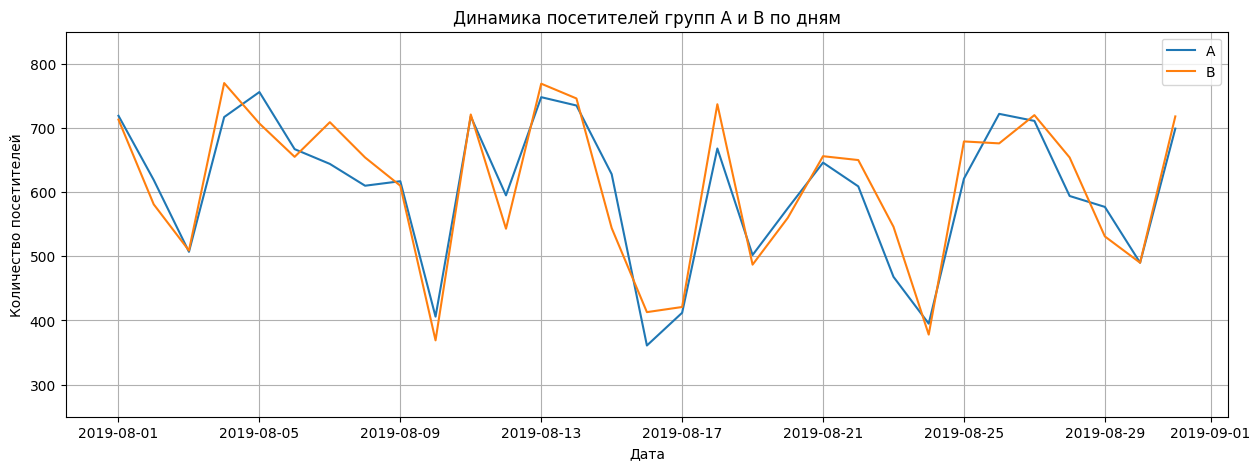

In [13]:
visitorsA = visitors.query('group == "A"')
visitorsB = visitors.query('group == "B"')

plt.figure(figsize=(15, 5))
plt.plot(visitorsA['date'],visitorsA['visitors'], label='A')
plt.plot(visitorsB['date'],visitorsB['visitors'], label='B')
plt.legend()
plt.grid()
plt.ylim((250,850))
plt.title('Динамика посетителей групп A и B по дням')
plt.ylabel('Количество посетителей')
plt.xlabel('Дата');

Судя по графику, расхождений между группами не обнаружено, трафик разделялся ровно.

<div style="border:solid blue 2px; padding: 20px">
    
**Вывод:**
- в А/В-тесте участвовало 1031 пользователь, 503 в А группе и 586 в В группе;
- 58 пользователей попали в обе группы;
- А/В-тест проводился в августе 2019 года;
- динамика посетителей по группам не имеет расхождений, трафик разделялся ровно.

##  Приоритизация гипотез

Проверка гипотез чаще всего стоит дорого, а ресурсов не хватает. Придётся выбрать, что будем тестировать, а чему скажем «нет». Чтобы максимизировать ожидаемое улучшение ключевых метрик бизнеса, сформулированные гипотезы приоритизируют.

In [14]:
pd.options.display.max_colwidth = 130
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


- `hypothesis` - краткое описание гипотезы;
- `reach` — скольких пользователей затронет изменение, которое вы хотите внести;
- `impact` — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
- `confidence` — насколько вы уверены, что это изменение повлияет на пользователей именно так; 
- `efforts` — сколько стоит протестировать эту гипотезу. 

### Применим фреймворк ICE и отсортируем по убиванию приоритета

ICE (от англ. impact, confidence, effort / ease «влияние, уверенность, усилия / простота») — один из самых популярных способов приоритизации задач:

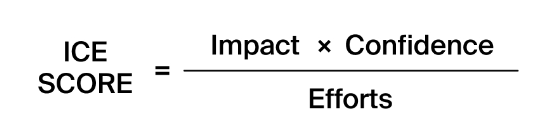

In [15]:
pd.options.display.max_colwidth = 130
hypothesis['ICE'] = round(
    hypothesis.impact * hypothesis.confidence / hypothesis.efforts
    , 2)
hypothesis[['hypothesis', 'ICE']].sort_values('ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


### Применим фреймворк RICE и отсортируем по убиванию приоритета

RICE (R от англ. reach, «охват») - модификация метода ICE:

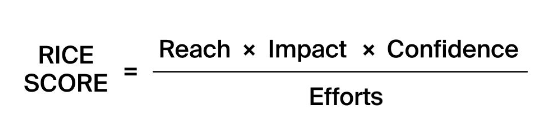

In [16]:
pd.options.display.max_colwidth = 130
hypothesis['RICE'] = round(
    hypothesis.reach * hypothesis.impact * hypothesis.confidence / hypothesis.efforts
    , 2)
hypothesis[['hypothesis', 'RICE']].sort_values('RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


<div style="border:solid blue 2px; padding: 20px">
    
**Вывод:**
- наиболее перспективные гипотезы по ICE: 
    1. Запустить акцию, дающую скидку на товар в день рождения;
    2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
    3. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
    4. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию;
    5. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа.
- наиболее перспективные гипотезы по RICE:
    1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
    2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
    3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
    4. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию	;
    5. Запустить акцию, дающую скидку на товар в день рождения.    
- в пятерке лидеров одни и те же гипотезы, но с разным приоритетом, так получилось, потому что в фреймворке RICE есть параметр Reach, и у каждой гипотезы он имеет свою оценку.

## Анализ A/B-теста

Создадим массив уникальных пар значений дат и групп теста методом drop_duplicates(): 

In [17]:
datesGroups = orders[['date','group']].drop_duplicates()

Соберём агрегированные кумулятивные по дням данные о заказах в несколько действий: 
- Получим строки таблицы orders, дата которых меньше или равна дате элемента из datesGroups, а группа теста равна группе из datesGroups. 
- Агрегируем значения. Вычислим максимальную дату. Для группы тоже рассчитаем максимум, и хотя она будет определённой, сделаем это, чтобы столбец 'group' не пропал из итогового вывода. Найдём число уникальных ID заказов и пользователей.
- Применим методы к каждой строке датафрейма: apply(axis=1) и отсортируем результаты по столбцам 'date' и 'group':

In [18]:
ordersAggregated = (
    datesGroups
    .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], 
                                           orders['group'] == x['group'])]\
    .agg({'date' : 'max', 
          'group' : 'max', 
          'orderId' : 'nunique', 
          'userId' : 'nunique', 
          'revenue' : 'sum'}), axis=1)
    .sort_values(by=['date','group'])
)

Аналогично получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина: 

In [19]:
visitorsAggregated = (
    datesGroups
    .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], 
                                             visitors['group'] == x['group'])]\
    .agg({'date' : 'max', 
          'group' : 'max', 
          'visitors' : 'sum'}), axis=1)
    .sort_values(by=['date','group'])
)

Объединим обе таблицы в одну с понятными названиями столбцов:

In [20]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, 
                                        left_on=['date', 'group'], 
                                        right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708
58,2019-08-30,A,545,493,4022970,18037
59,2019-08-30,B,620,567,5774631,18198
60,2019-08-31,A,557,503,4084803,18736


In [21]:
print(f"Минимальная дата заказов: {cumulativeData.date.min()}, максимальная: {cumulativeData.date.max()}")

Минимальная дата заказов: 2019-08-01 00:00:00, максимальная: 2019-08-31 00:00:00


Даты соответствуют периоду исследования.

### График кумулятивной выручки по группам

Создадим датафреймы с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А и В

In [22]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

Строим график выручки группы А и В:

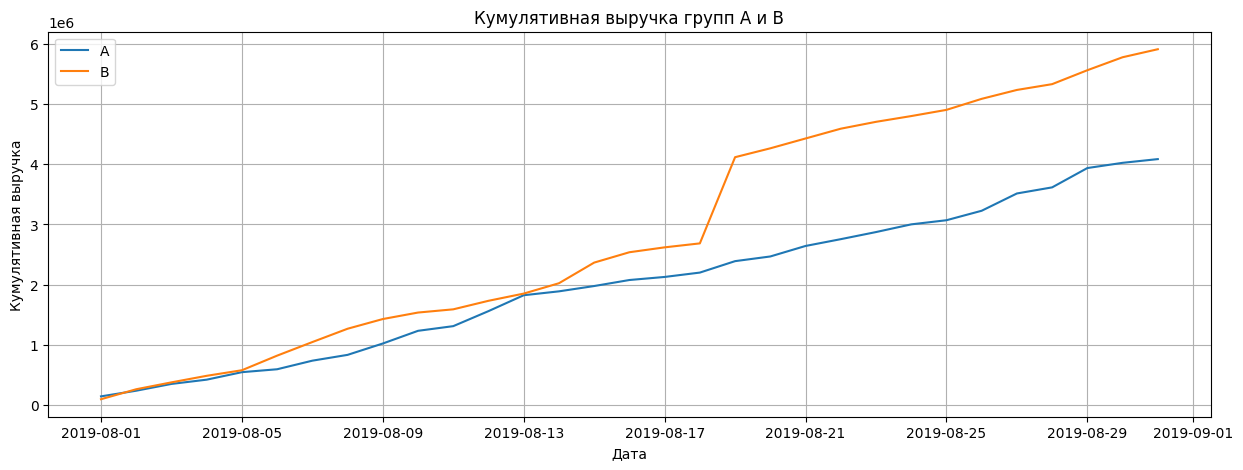

In [23]:
plt.figure(figsize=(15, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend()
plt.grid()
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка')
plt.title('Кумулятивная выручка групп А и В');

- выручка почти равномерно увеличивается в течении всего теста;
- резкий рост на графике может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке;
- в середине теста группа В ускоряется впредет и продолжает лидировать весь остаток теста. Похоже, что аномально большие заказы всё-таки влияют на результаты. При заключительном анализе их нужно удалить.

<div style="border:solid blue 2px; padding: 20px">
    
**Вывод:**
- группа В лидирует на протяжении всего теста;
- резкий рост в группе В после середины теста указывает на возможные выбросы, что может исказить результаты.

### График кумулятивного среднего чека по группам

Разделим кумулятивную выручку на кумулятивное число заказов:

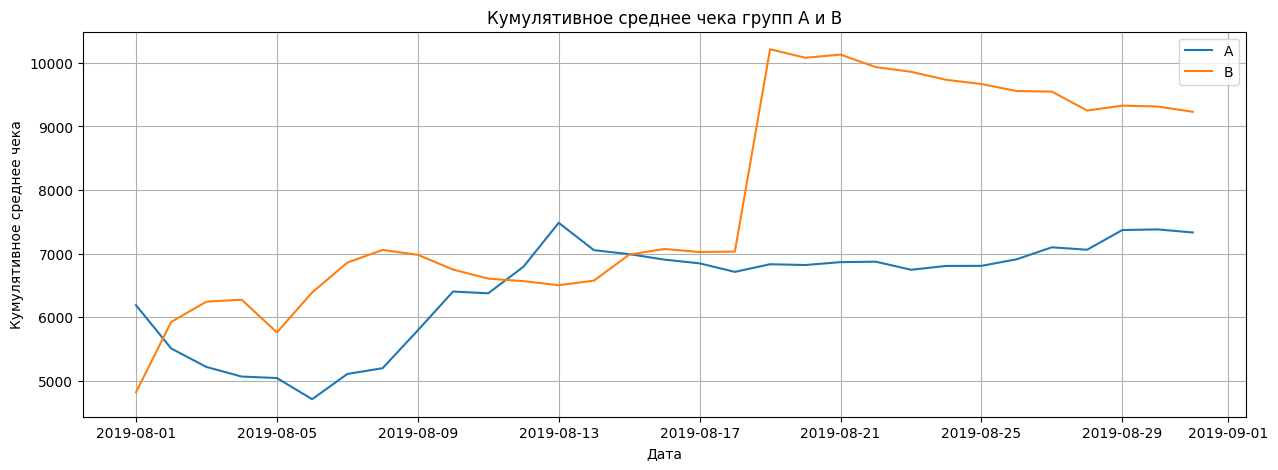

In [24]:
plt.figure(figsize=(15, 5))
plt.plot(cumulativeRevenueA['date'], 
         cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], 
         cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.grid()
plt.xlabel('Дата')
plt.ylabel('Кумулятивное среднее чека')
plt.title('Кумулятивное среднее чека групп А и В');

<div style="border:solid blue 2px; padding: 20px">
    
**Вывод:**
- лидер группа В;    
- в середине теста наблюдаем выбросы у группы В, без них возможно, результат был бы другим.

### График относительного изменения кумулятивного среднего чека группы B к группе A

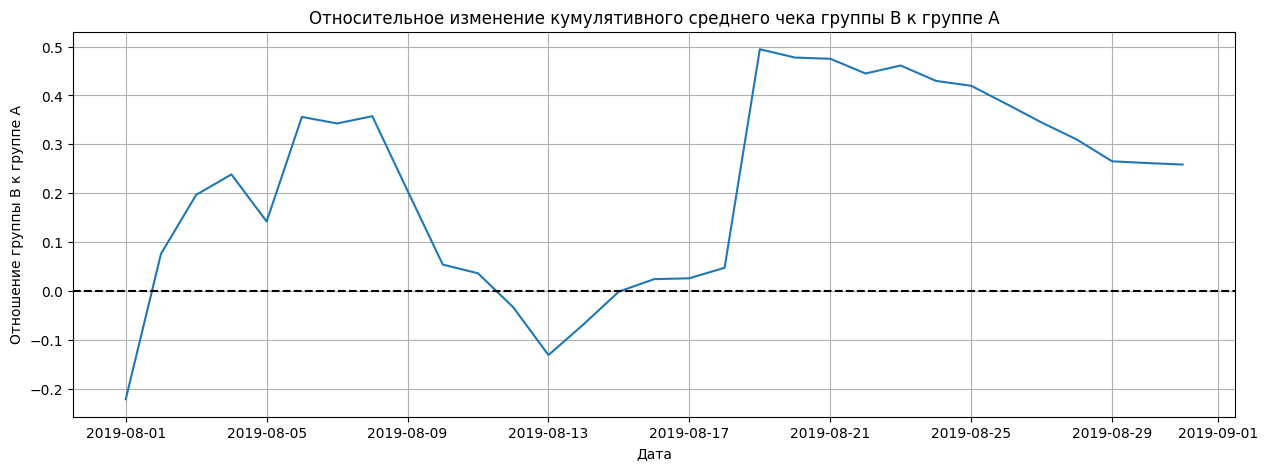

In [25]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, 
                                                   left_on='date', 
                                                   right_on='date', 
                                                   how='left', 
                                                   suffixes=['A', 'B'])

plt.figure(figsize=(15, 5))
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.grid()
plt.xlabel('Дата')
plt.ylabel('Отношение группы В к группе А')
plt.title('Относительное изменение кумулятивного среднего чека группы В к группе А')
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--');

<div style="border:solid blue 2px; padding: 20px">
    
**Вывод:**
- группа В имеет преимещество, лишь в начале и в середине теста она проигрывала группе А.

### График кумулятивного среднего количества заказов на посетителя по группам

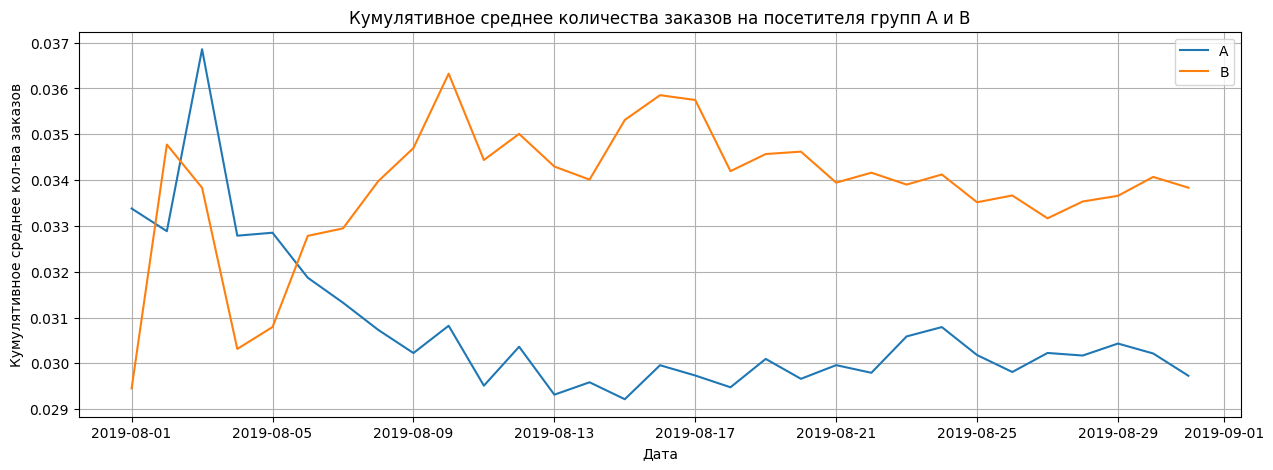

In [26]:
cumulativeOrdersA = cumulativeData[cumulativeData['group']=='A'][['date', 'orders', 'visitors']]
cumulativeOrdersB = cumulativeData[cumulativeData['group']=='B'][['date', 'orders', 'visitors']]
cumulativeOrdersA['ratioA'] = cumulativeOrdersA['orders']/cumulativeOrdersA['visitors']
cumulativeOrdersB['ratioB'] = cumulativeOrdersB['orders']/cumulativeOrdersB['visitors']

plt.figure(figsize=(15, 5))
plt.plot(cumulativeOrdersA['date'], cumulativeOrdersA['ratioA'], label='A')
plt.plot(cumulativeOrdersB['date'], cumulativeOrdersB['ratioB'], label='B')
plt.legend() 
plt.grid()
plt.xlabel('Дата')
plt.ylabel('Кумулятивное среднее кол-ва заказов')
plt.title('Кумулятивное среднее количества заказов на посетителя групп А и В');

<div style="border:solid blue 2px; padding: 20px">
    
**Вывод:**
- по центральной предельной теореме значение кумулятиных метрик часто сходится и устанавливается около некоторого среднего, в начале теста были колебания в обеих группах, график стабилизировался к концу теста;
- группа В стабильно делает больше заказов.

### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

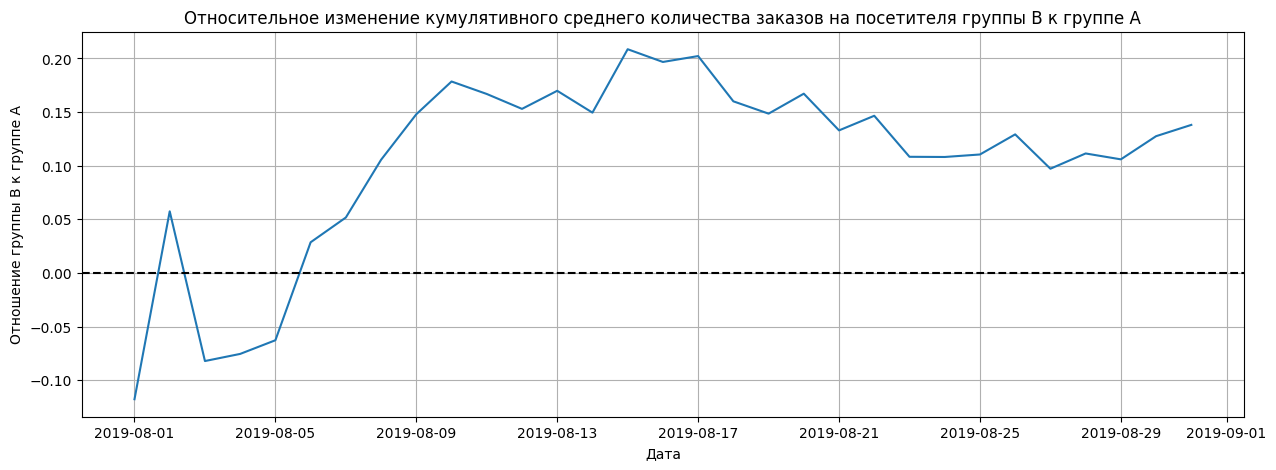

In [27]:
# собираем данные в одном датафрейме
mergedCumulativeOrders  = cumulativeOrdersA.merge(cumulativeOrdersB, 
                                                   left_on='date', 
                                                   right_on='date', 
                                                   how='left', 
                                                   suffixes=['A', 'B'])
plt.figure(figsize=(15, 5))
# cтроим отношение средних чеков
plt.plot(mergedCumulativeOrders['date'], (mergedCumulativeOrders['ratioB']/mergedCumulativeOrders['ratioA'])-1)
plt.grid()
plt.xlabel('Дата')
plt.ylabel('Отношение группы В к группе А')
plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы В к группе А')
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--');

<div style="border:solid blue 2px; padding: 20px">
    
**Вывод:**
- график сообщает, что результаты группы В лучше А.

### График количества заказов по пользователям

Построим точечный график количества заказов по пользователям:

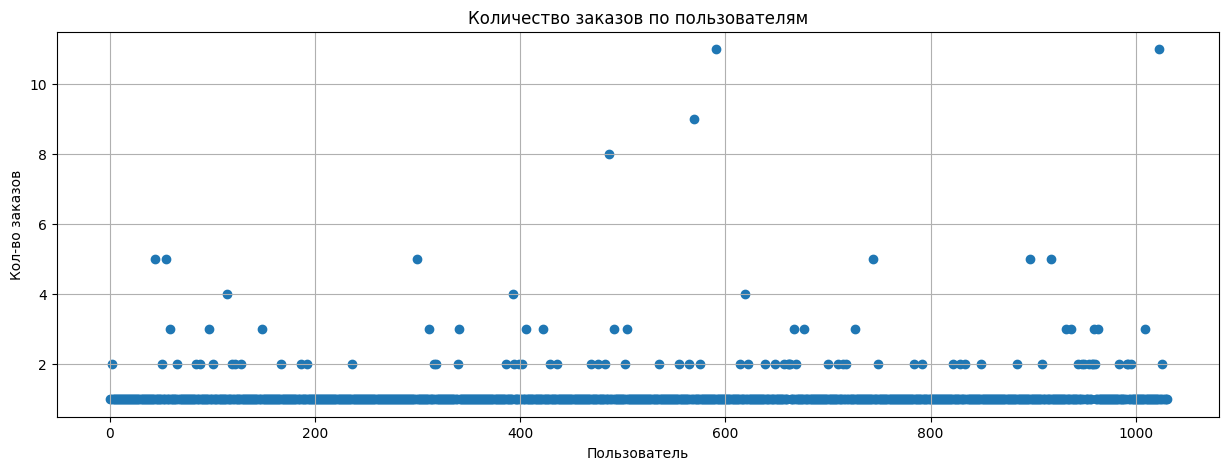

In [28]:
ordersByUsers = (
    orders.groupby('userId', as_index=False)
    .agg({'orderId': 'nunique'})
)
ordersByUsers.columns = ['userId', 'orders']
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.figure(figsize=(15, 5))
plt.scatter(x_values, ordersByUsers['orders'])
plt.grid()
plt.xlabel('Пользователь')
plt.ylabel('Кол-во заказов')
plt.title('Количество заказов по пользователям');

In [29]:
ordersByUsers.orders.value_counts()

1     937
2      64
3      17
5       6
4       3
11      2
8       1
9       1
Name: orders, dtype: int64

<div style="border:solid blue 2px; padding: 20px">
    
**Вывод:**
- большинство пользователей совершали не более 1 заказа, некоторые 2, и гораздо реже 3 и более.

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберим границу для определения аномальных пользователей

In [30]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

<div style="border:solid blue 2px; padding: 20px">
    
**Вывод:**
- 5% пользователей делают больше 2-х заказов;
- 1% делает более 4-х заказов;
- для дальнейшего анализа выберим границу на уровне 95-го перцентиля.

### Точечный график стоимостей заказов

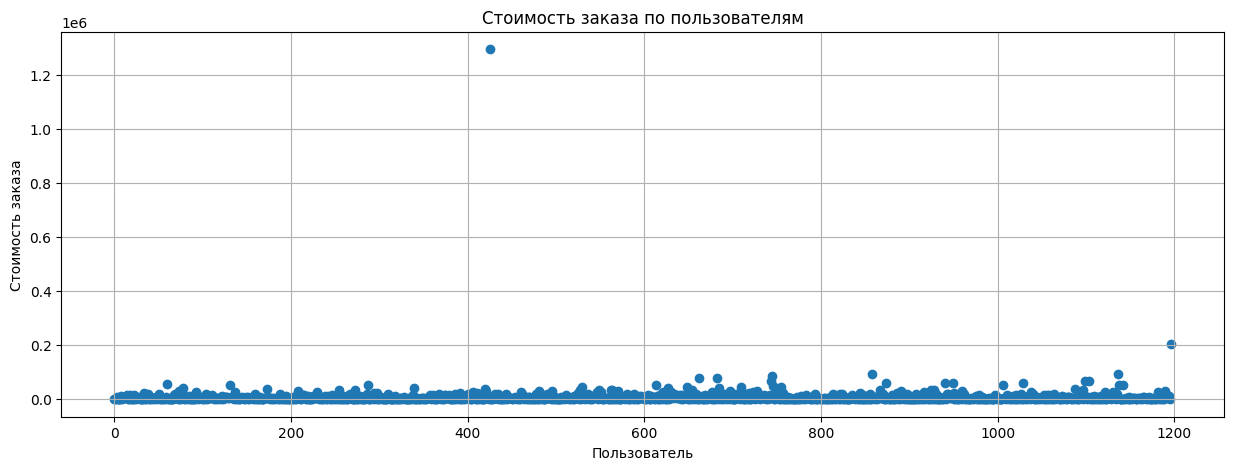

In [31]:
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(15, 5))
plt.scatter(x_values, orders['revenue'])
plt.grid()

plt.xlabel('Пользователь')
plt.ylabel('Стоимость заказа')
plt.title('Стоимость заказа по пользователям');

Посмотрим график поближе, и воспользуемся describe(), чтобы узнать среднюю, медианную и тп.

In [32]:
orders['revenue'].describe()

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64

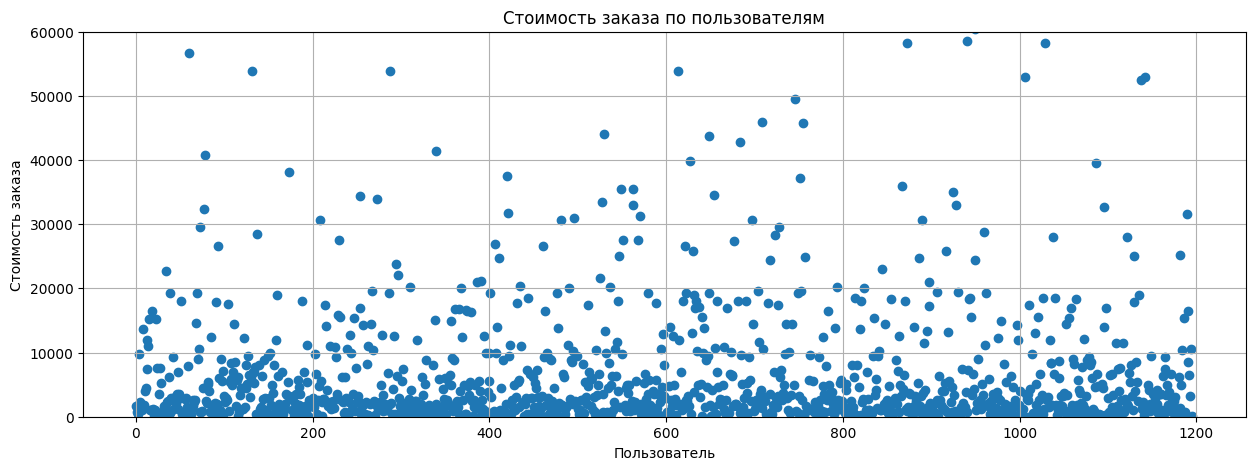

In [33]:
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(15, 5))
plt.scatter(x_values, orders['revenue'])
plt.grid()
plt.ylim((0,60000))
plt.xlabel('Пользователь')
plt.ylabel('Стоимость заказа')
plt.title('Стоимость заказа по пользователям');

<div style="border:solid blue 2px; padding: 20px">
    
**Вывод:**
- на графике наблюдаем выбросы, которые искажают результаты.
- медианная стоимость заказа ~300 у.е..

### Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберим границу для определения аномальных заказов

In [34]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

<div style="border:solid blue 2px; padding: 20px">
    
**Вывод:**
- 5% пользователей совершают заказы на 28000 у.е.;
- 1% совершают заказы на 58233 у.е.;
- для дальнейшего анализа выберим границу на уровне 95-го перцентиля.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Создадим датафрейм data со следующими названиями столбцов:
- `date` — дата;
- `ordersPerDateA` — количество заказов в выбранную дату в группе A;
- `revenuePerDateA` — суммарная выручка в выбранную дату в группе A;
- `ordersPerDateB` — количество заказов в выбранную дату в группе B;
- `revenuePerDateB` — суммарная выручка в выбранную дату в группе B;
- `ordersCummulativeA` — суммарное число заказов до выбранной даты включительно в группе A;
- `revenueCummulativeA` — суммарная выруч
ка до выбранной даты включительно в группе A;
- `ordersCummulativeB` — суммарное количество заказов до выбранной даты включительно в группе B;
- `revenueCummulativeB` — суммарная выручка до выбранной даты включительно в группе B;
- `visitorsPerDateA` — количество пользователей в выбранную дату в группе A;
- `visitorsPerDateB` — количество пользователей в выбранную дату в группе B;
- `visitorsCummulativeA` — количество пользователей до выбранной даты включительно в группе A;
- `visitorsCummulativeB` — количество пользователей до выбранной даты включительно в группе B.

In [35]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Объявим переменные sampleA и sampleB, в которых пользователям с заказами будет соответствовать число заказов пользователя. А пользователям без заказов — нули:

In [36]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Введем основную и альтернативные гипотезы:
```
H_0: `Среднее количество заказов между группами по "сырым" данным не различаются`
H_1: `Среднее количество заказов между группами по "сырым" данным различаются`
alpha = 0.05
```
Посчитаем статистическую значимость различия среднего количества заказов по результатам месяца теста. Применим тест Манна-Уитни:

In [37]:
print("Значение p-value: {0:.4f}".format(
    stats.mannwhitneyu(sampleA, sampleB)[1])
     )

Значение p-value: 0.0168


Вычислим и выведим относительное различие в среднем между группами:

In [38]:
print("Относительное различие в среднем между группами: {0:.4f}".format(
    sampleB.mean() / sampleA.mean() - 1)
     )

Относительное различие в среднем между группами: 0.1381


<div style="border:solid blue 2px; padding: 20px">
    
**Вывод:**
- анализ «сырых данных» сообщает, что в среднем количестве заказов между группами есть статистически значимые различия;
- P-value меньше 0.05, отвергаем нулевую гипотезу;
- среднее количество заказов между группами различается на 13.8%.    

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

Введем основную и альтернативные гипотезы:
```
H_0: `Средние чеки заказов между группами по "сырым" данным не различается`
H_1: `Средние чеки заказов между группами по "сырым" данным  различается`
alpha = 0.05
```

In [39]:
print("Значение p-value: {0:.4f}".format(
    stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                 orders[orders['group']=='B']['revenue'])[1])
     )
print("Относительное различие в среднем между группами: {0:.4f}".format(
    orders[orders['group']=='B']['revenue'].mean()/
              orders[orders['group']=='A']['revenue'].mean()-1)
     )

Значение p-value: 0.7293
Относительное различие в среднем между группами: 0.2587


<div style="border:solid blue 2px; padding: 20px">
    
**Вывод:**
- не получилось отвергнуть нулевую гипотезу, P-value больше 0.05;
- статистически значимых отличий в среднем чеке между группами нет;
- относительное различие среднего чека между группами ~25.9%.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Найденные раньше 95-й и 99-й перцентили средних чеков равны 28000 и 58233 у.е.. А 95-й и 99-й перцентили количества заказов на одного пользователя равны 2 и 4 заказа на пользователя.

Примем за аномальных пользователей тех, кто совершил от 2 заказов или совершил заказ дороже 28000 у.е..

Сделаем срезы пользователей с числом заказов больше 2 — usersWithManyOrders и пользователей, совершивших заказы дороже 28000 — usersWithExpensiveOrders. 

Объединим их в таблице abnormalUsers. Узнаем, сколько всего аномальных пользователей атрибутом shape.

In [40]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > np.percentile(ordersByUsers['orders'], 95)]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > np.percentile(ordersByUsers['orders'], 95)]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'], 95)]['userId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0])

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: userId, dtype: int64
74


Всего 74 аномальных пользователей. 

Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. 

Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [41]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Введем основную и альтернативные гипотезы:
```
H_0: `Среднее количество заказов между группами по "очищенным" данным не различаются`
H_1: `Среднее количество заказов между группами по "очищенным" данным различаются`
alpha = 0.05
```

In [42]:
print("Значение p-value: {0:.4f}".format(
    stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1])
     )
print("Относительное различие в среднем между группами: {0:.4f}".format(
    sampleBFiltered.mean()/sampleAFiltered.mean()-1)
     )

Значение p-value: 0.0130
Относительное различие в среднем между группами: 0.1727


<div style="border:solid blue 2px; padding: 20px">
    
**Вывод:**
- отвергаем нулевую гипотезу, P-value меньше 0.05;
- между средними количествами заказов между группами есть статистически значимое различие;
- относительное различие среднего чека между группами ~17.3%.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

Введем основную и альтернативные гипотезы:
```
H_0: `Средние чеки заказов между группами по "очищенным" данным не различается`
H_1: `Средние чеки заказов между группами по "очищенным" данным  различается`
alpha = 0.05
```

In [43]:
print("Значение p-value: {0:.4f}".format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(orders['group'] == 'A',
                       np.logical_not(orders['userId'].isin(abnormalUsers)),
                              )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print("Относительное различие среднего чека очищенной группы B: {0:.4f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['userId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['userId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

Значение p-value: 0.7385
Относительное различие среднего чека очищенной группы B: -0.0196


<div style="border:solid blue 2px; padding: 20px">
    
**Вывод:**
- не получилось отвергнуть нулевую гипотезу, P-value больше 0.05;
- статистически значимых отличий в среднем чеке между группами нет;
- относительное различие среднего чека между группами -1.96%.

### Принятие решения по результатам теста

**Результаты теста статистической значимости различий между группами А и В:**

|      | "Сырые" данные| "Очищенные" данные|
| -------------       | ------------- |------------- |
| Среднее количество заказов  | Есть различие  | Есть различие  |
| Средний чек заказа       | Нет различий  |Нет различий  |

**Результаты теста относительного различия среднего между группами А и В:**

|      | "Сырые" данные| "Очищенные" данные|
| -------------       | ------------- |------------- |
| Среднее количество заказов  | 13.8%  | 17.3%  |
| Средний чек заказа       | 25.9%  |-1.96%  |

По результатам теста, мы выяснили, что тест Манна-Уитни устойчив к шумам и выбросам, после очистки данных статистические результаты между группами не изменились, изменились лишь относительные отличия.

Перед принятием решения, сопоставим графики по "сырым" и "очищенным" данным, для нагладности:

Сделаем датафрейм с очищенными данными:

In [44]:
orders_filtered = orders[~(orders['userId'].isin(abnormalUsers))]
datesGroups_filtered = orders_filtered[['date','group']].drop_duplicates()

ordersAggregated_filtered = datesGroups_filtered.apply(
    lambda x: orders_filtered[
        np.logical_and(
            orders_filtered['date'] <= x['date'], 
            orders_filtered['group'] == x['group'])
        ].agg(
            {'date' : 'max', 
             'group' : 'max', 
             'orderId' : 'nunique', 
             'userId' : 'nunique', 
             'revenue' : 'sum'}), 
             axis=1).sort_values(by=['date', 'group'])

visitorsAggregated_filtered = datesGroups_filtered.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], 
            visitors['group'] == x['group'])
        ].agg({'date' : 'max', 
               'group' : 'max', 
               'visitors' : 'sum'}), 
               axis=1).sort_values(by=['date','group'])

cumulativeData_filtered = ordersAggregated_filtered.merge(visitorsAggregated_filtered, 
                                                          left_on=['date', 'group'], 
                                                          right_on=['date', 'group'])

cumulativeData_filtered.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

cumulativeRevenueA_filtered = cumulativeData_filtered[cumulativeData_filtered['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB_filtered = cumulativeData_filtered[cumulativeData_filtered['group']=='B'][['date','revenue', 'orders']]

#### График кумулятивной выручки по группам

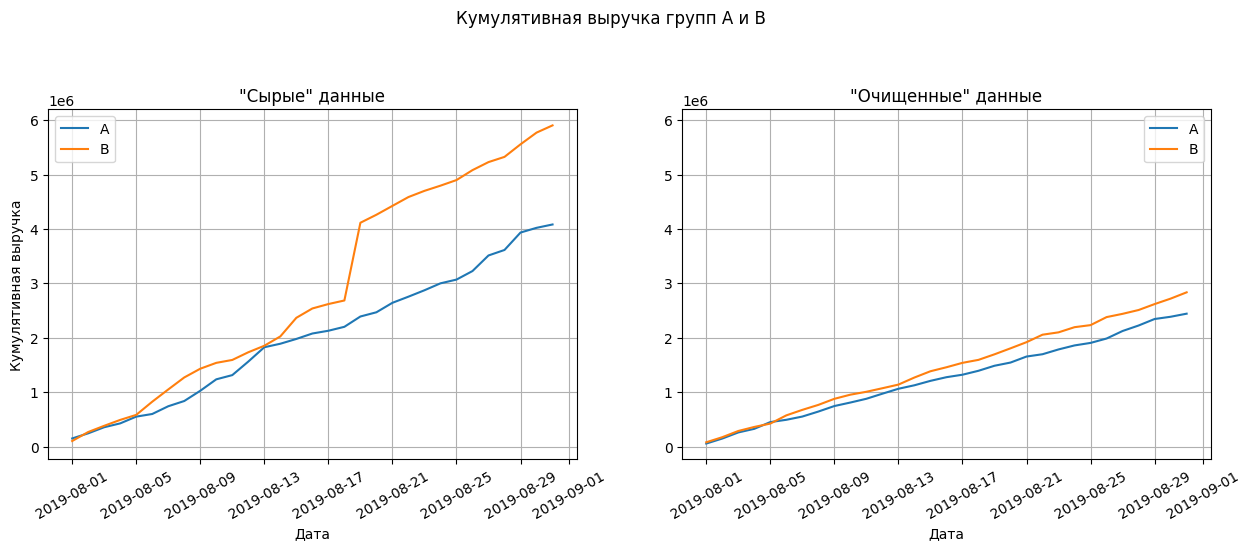

In [45]:
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Кумулятивная выручка групп А и В')

ax1 = plt.subplot(2, 2, 1)
ax1.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
ax1.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend()
plt.grid()
plt.xticks(rotation=30)
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка')
plt.title('"Сырые" данные')

ax2 = plt.subplot(2, 2, 2, sharey = ax1)
ax2.plot(cumulativeRevenueA_filtered['date'], cumulativeRevenueA_filtered['revenue'], label='A')
ax2.plot(cumulativeRevenueB_filtered['date'], cumulativeRevenueB_filtered['revenue'], label='B')
plt.legend()
plt.grid()
plt.xticks(rotation=30)
plt.xlabel('Дата')
plt.title('"Очищенные" данные');

- после очистки от выбросов, лидирует так же группа В.

#### График кумулятивного среднего чека по группам

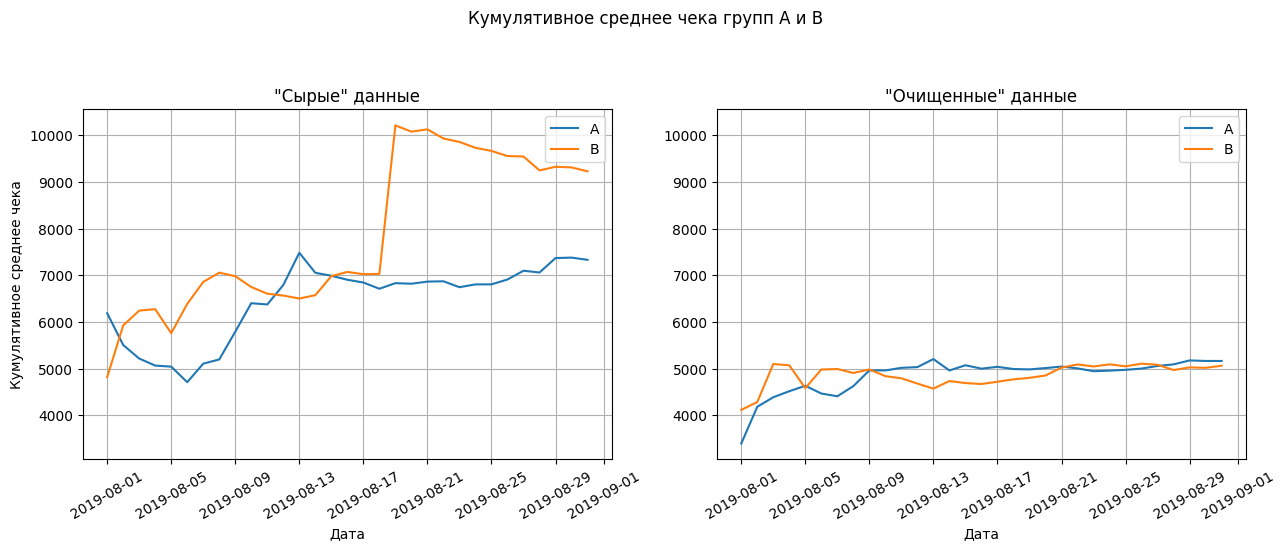

In [46]:
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Кумулятивное среднее чека групп А и В')

ax1 = plt.subplot(2, 2, 1)
ax1.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
ax1.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.grid()
plt.xticks(rotation=30)
plt.xlabel('Дата')
plt.ylabel('Кумулятивное среднее чека')
plt.title('"Сырые" данные')

ax2 = plt.subplot(2, 2, 2, sharey = ax1)
ax2.plot(cumulativeRevenueA_filtered['date'], 
         cumulativeRevenueA_filtered['revenue']/cumulativeRevenueA_filtered['orders'], label='A')
ax2.plot(cumulativeRevenueB_filtered['date'], 
         cumulativeRevenueB_filtered['revenue']/cumulativeRevenueB_filtered['orders'], label='B')
plt.legend()
plt.grid()
plt.xticks(rotation=30)
plt.xlabel('Дата')
plt.title('"Очищенные" данные');

- после очистки от выбросов, волатильность уменьшилась, и под конец теста обе группы вышли на плато ~5000 у.е..

#### График относительного изменения кумулятивного среднего чека группы B к группе A

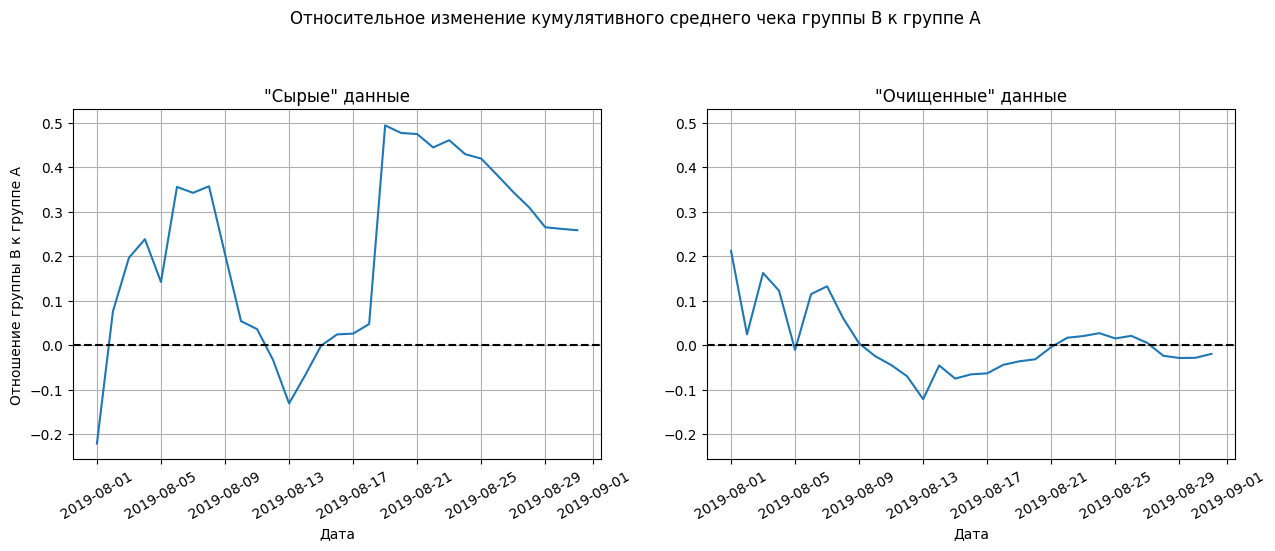

In [47]:
mergedCumulativeRevenue_filtered = cumulativeRevenueA_filtered.merge(cumulativeRevenueB_filtered, 
                                                   left_on='date', 
                                                   right_on='date', 
                                                   how='left', 
                                                   suffixes=['A', 'B'])

fig = plt.figure(figsize=(15, 10))
fig.suptitle('Относительное изменение кумулятивного среднего чека группы B к группе A')
ax1 = plt.subplot(2, 2, 1)
ax1.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.grid()
plt.xticks(rotation=30)
plt.xlabel('Дата')
plt.ylabel('Отношение группы В к группе А')
plt.title('"Сырые" данные')
plt.axhline(y=0, color='black', linestyle='--')

ax2 = plt.subplot(2, 2, 2, sharey = ax1)
ax2.plot(mergedCumulativeRevenue_filtered['date'], 
         (mergedCumulativeRevenue_filtered['revenueB']/mergedCumulativeRevenue_filtered['ordersB'])/
         (mergedCumulativeRevenue_filtered['revenueA']/mergedCumulativeRevenue_filtered['ordersA'])-1)
plt.grid()
plt.xticks(rotation=30)
plt.xlabel('Дата')
plt.title('"Очищенные" данные')
plt.axhline(y=0, color='black', linestyle='--');

- здесь так же видно, что подтверждает статистический тест, разница между группами отсуствует.

#### График кумулятивного среднего количества заказов на посетителя по группам

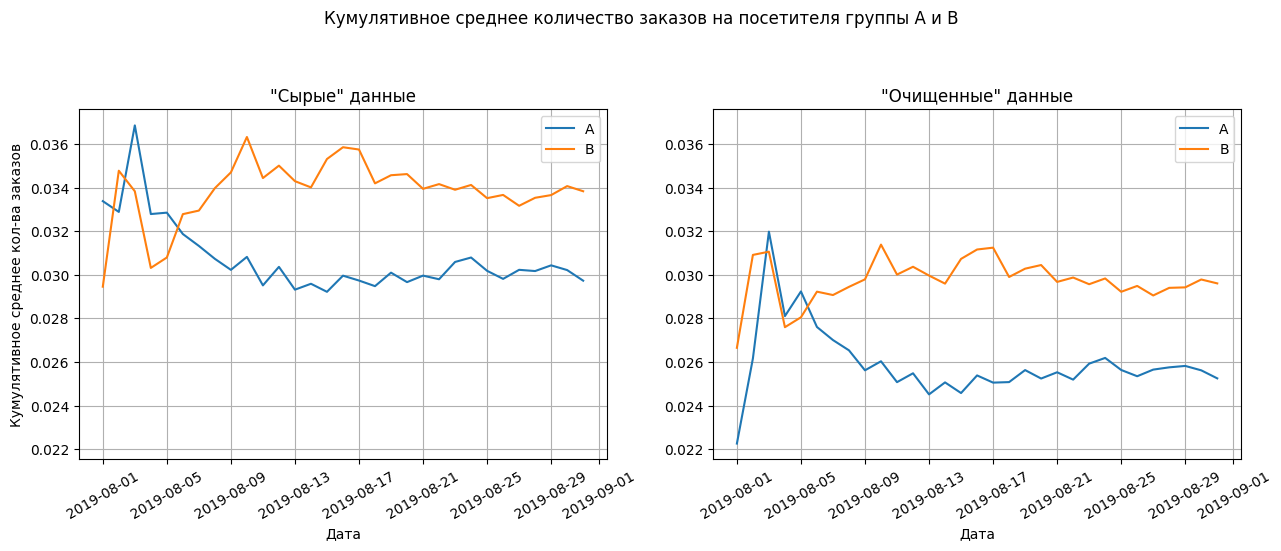

In [48]:
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Кумулятивное среднее количество заказов на посетителя группы А и В')

ax1 = plt.subplot(2, 2, 1)
ax1.plot(cumulativeOrdersA['date'], cumulativeOrdersA['ratioA'], label='A')
ax1.plot(cumulativeOrdersB['date'], cumulativeOrdersB['ratioB'], label='B')
plt.legend()
plt.grid()
plt.xticks(rotation=30)
plt.xlabel('Дата')
plt.ylabel('Кумулятивное среднее кол-ва заказов')
plt.title('"Сырые" данные')


cumulativeOrdersA_filtered = cumulativeData_filtered[cumulativeData_filtered['group']=='A'][['date', 'orders', 'visitors']]
cumulativeOrdersB_filtered = cumulativeData_filtered[cumulativeData_filtered['group']=='B'][['date', 'orders', 'visitors']]
cumulativeOrdersA_filtered['ratioA'] = cumulativeOrdersA_filtered['orders']/cumulativeOrdersA_filtered['visitors']
cumulativeOrdersB_filtered['ratioB'] = cumulativeOrdersB_filtered['orders']/cumulativeOrdersB_filtered['visitors']

ax2 = plt.subplot(2, 2, 2, sharey = ax1)
ax2.plot(cumulativeOrdersA_filtered['date'], 
         cumulativeOrdersA_filtered['ratioA'], label='A')
ax2.plot(cumulativeOrdersB_filtered['date'], 
         cumulativeOrdersB_filtered['ratioB'], label='B')
plt.legend()
plt.grid()
plt.xticks(rotation=30)
plt.xlabel('Дата')
plt.title('"Очищенные" данные');

- группа В лидирует и после очистки данных от выбросов.

#### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

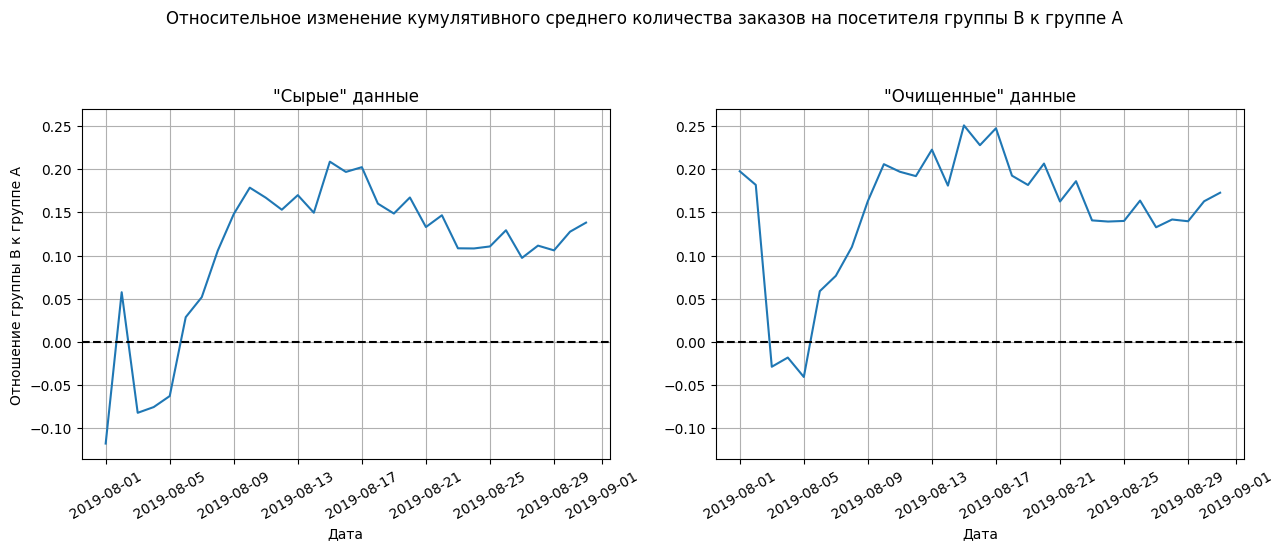

In [49]:
mergedCumulativeOrders_filtered = cumulativeOrdersA_filtered.merge(cumulativeOrdersB_filtered, 
                                                 left_on='date', 
                                                 right_on='date', 
                                                 how='left', 
                                                 suffixes=['A', 'B'])

fig = plt.figure(figsize=(15, 10))
fig.suptitle('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A')
ax1 = plt.subplot(2, 2, 1)
ax1.plot(mergedCumulativeOrders['date'], 
         (mergedCumulativeOrders['ratioB']/mergedCumulativeOrders['ratioA'])-1)
plt.grid()
plt.xticks(rotation=30)
plt.xlabel('Дата')
plt.ylabel('Отношение группы В к группе А')
plt.title('"Сырые" данные')
plt.axhline(y=0, color='black', linestyle='--')

ax2 = plt.subplot(2, 2, 2, sharey = ax1)
ax2.plot(mergedCumulativeOrders_filtered['date'], 
         (mergedCumulativeOrders_filtered['ratioB']/mergedCumulativeOrders_filtered['ratioA'])-1)
plt.grid()
plt.xticks(rotation=30)
plt.xlabel('Дата')
plt.title('"Очищенные" данные')
plt.axhline(y=0, color='black', linestyle='--');

- по очищенным данным так же лидиует группа В.

<div style="border:solid blue 2px; padding: 20px">
    
**Вывод:**
- исходя из исследования, тест следует остановить и зафиксировать победу группы B.

## Выводы

Получив данные, мы изучили их и сделали преодобработку, после чего провели приоритизацию гипотез, и выявили:
- наиболее перспективные гипотезы по ICE: 
    1. Запустить акцию, дающую скидку на товар в день рождения;
    2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
    3. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
    4. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию;
    5. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа.
- наиболее перспективные гипотезы по RICE:
    1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
    2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
    3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
    4. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию	;
    5. Запустить акцию, дающую скидку на товар в день рождения.    
- в пятерке лидеров одни и те же гипотезы, но с разным приоритетом, так получилось, потому что в фреймворке RICE есть параметр Reach, и у каждой гипотезы он имеет свою оценку.

Для дальнейшего исследования А/В-теста мы посчитали 95-й и 99-й перцентили количества и стоимости заказов, и выбрали границу для определения аномальных пользователей, удалив их, мы получили "очищенные" данные.

В ходе работы были построены графики для "сырых" и "очищенных данных":
- график кумулятивной выручки по группам;
- график кумулятивного среднего чека по группам;
- график относительного изменения кумулятивного среднего чека группы B к группе A;
- график кумулятивного среднего количества заказов по группам;
- график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A;
- точечный график количества заказов по пользователям;
- точечный график стоимостей заказов.

Выявлено:
- по кумулятивной выручки лидирует группа В;
- по кумулятивной среднего чека лидирует группа В;
- относительное изменение среднего чека между группами отсуствует;
- по среднему количеству заказов на посетителя лидирует группа В;
- относительное изменение среднего количества заказов на посетителя лидирует группа В.

*Исходя из результатов, в исследовании А/В теста **побеждает группа В***, тест следует остановить, достигнута статистическая значимость.

**Результаты теста статистической значимости различий между группами А и В:**

|      | "Сырые" данные| "Очищенные" данные|
| -------------       | ------------- |------------- |
| Среднее количество заказов  | Есть различие  | Есть различие  |
| Средний чек заказа       | Нет различий  |Нет различий  |

**Результаты теста относительного различия среднего между группами А и В:**

|      | "Сырые" данные| "Очищенные" данные|
| -------------       | ------------- |------------- |
| Среднее количество заказов  | 13.8%  | 17.3%  |
| Средний чек заказа       | 25.9%  |-1.96%  |